In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [8]:
# Import data 
target_assay = 'transduction'  # nor_package
array = 'seq'    #  RNA


df_all = pd.read_csv('../data/1stseq_aa_transduction.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[[array, target_assay]]
df= df.sort_values(by=target_assay)

#Fill in the nan data and replace the inf value
df[target_assay] = df[target_assay].fillna(0)  
df[target_assay] = df[target_assay].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[target_assay,array])
df = df.iloc[::20]
df

,seq,transduction
5233,TTTCGGCAGGGTTCGGTTTCT,-16.459544
6167,AGGATGGCGGTTCGTGGGGAG,-13.292589
9685,GATAGGGGGGTTCTTCCTTCG,-12.670051
6065,ACTAGTGGGGTGCGGGAGGGG,-12.210162
2533,ATTATGGCTAGGGGGACGGCG,-11.927898
...,...,...
7154,TCTAATGTTAGGAAGCATATT,5.791499
5121,AATCCTCCTATGCATGGTTAT,6.067939
2466,CGTCAGACTATGGTTCATGCG,6.471415
5814,GGTCGTTTGAGTACGAATGGG,6.918905


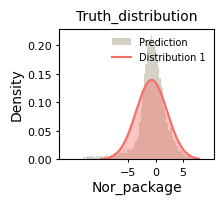

In [9]:
nor_package = df_all[np.isfinite(df_all[target_assay])][target_assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 8, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

#### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [10]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array,target_assay_col=target_assay)
train_df['Y--transduction'] = train_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])
test_df['Y--transduction'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])
prepped_df['Y--transduction'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')[target_assay])

In [11]:
train_df

,seq,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x411,x412,x413,x414,x415,x416,x417,x418,x419,Y--transduction
0,TTTCGGCAGGGTTCGGTTTCT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-16.459544
1,AGGATGGCGGTTCGTGGGGAG,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-13.292589
2,GATAGGGGGGTTCTTCCTTCG,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-12.670051
3,ACTAGTGGGGTGCGGGAGGGG,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-12.210162
4,ATTATGGCTAGGGGGACGGCG,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-11.927898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,TCTAATGTTAGGAAGCATATT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.791499
456,AATCCTCCTATGCATGGTTAT,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.067939
457,CGTCAGACTATGGTTCATGCG,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.471415
458,GGTCGTTTGAGTACGAATGGG,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.918905


Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [12]:
X, Y = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

#### VAE training

Default parameterization (used in paper):

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [13]:
# SVAE parameters (same as default)
input_dim = 420
latent_dim = 2
enc_hidden_dims = [300,120]
dec_hidden_dims = [120,300]
reg_hidden_dims = [300,30]

# training parameters 
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

outpath = 'pretrain/vae/1st_seq_nor_transduction'

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=420, latent_dim=6, enc_hidden_dims=[300,120], dec_hidden_dims=[120,300], reg_hidden_dims=[300,30], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 420)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  163872    ['encoder_input[0][0]',       
                              (None, 6),                             'encoder_input[0][0]']       
                              (None, 6)]                                                          
                                                                                                  
 tf.concat_1 (TFOpLambda)    (None, 426)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [14]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,train_df, 
                        optimizer=optimizer,
                        loss_weights=loss_weights           
                        )


Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
216/216 [==============================] - 4s 20ms/step - train_model_loss: 51.4388 - train_reconstruction_loss: 36.1252 - train_kl_loss: 0.8020 - train_regression_loss: 9.6938 - val_model_loss: 39.9483 - val_reconstruction_loss: 26.6878 - val_kl_loss: 0.8513 - val_regression_loss: 8.2610
INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 2
216/216 [==============================] - 4s 20ms/step - train_model_loss: 40.1836 - train_reconstruction_loss: 27.9352 - train_kl_loss: 0.6994 - train_regression_loss: 7.7090 - val_model_loss: 39.1633 - val_reconstruction_loss: 25.2657 - val_kl_loss: 0.7056 - val_regression_loss: 11.2010


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 3
216/216 [==============================] - 4s 17ms/step - train_model_loss: 36.7306 - train_reconstruction_loss: 24.1269 - train_kl_loss: 0.7074 - train_regression_loss: 8.0361 - val_model_loss: 31.6303 - val_reconstruction_loss: 23.5714 - val_kl_loss: 0.4898 - val_regression_loss: 5.0427


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 4
216/216 [==============================] - 4s 19ms/step - train_model_loss: 36.0724 - train_reconstruction_loss: 23.4467 - train_kl_loss: 0.4373 - train_regression_loss: 8.2440 - val_model_loss: 33.0226 - val_reconstruction_loss: 23.1568 - val_kl_loss: 0.3554 - val_regression_loss: 5.7704


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 5
216/216 [==============================] - 4s 16ms/step - train_model_loss: 34.8715 - train_reconstruction_loss: 23.5552 - train_kl_loss: 0.2583 - train_regression_loss: 7.3916 - val_model_loss: 36.6965 - val_reconstruction_loss: 23.3167 - val_kl_loss: 0.1879 - val_regression_loss: 9.0542


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 6
216/216 [==============================] - 4s 18ms/step - train_model_loss: 34.0188 - train_reconstruction_loss: 23.1814 - train_kl_loss: 0.1937 - train_regression_loss: 7.1148 - val_model_loss: 35.4632 - val_reconstruction_loss: 22.8810 - val_kl_loss: 0.2475 - val_regression_loss: 7.0623


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 7
216/216 [==============================] - 3s 16ms/step - train_model_loss: 33.9226 - train_reconstruction_loss: 23.1712 - train_kl_loss: 0.2059 - train_regression_loss: 7.1097 - val_model_loss: 31.1179 - val_reconstruction_loss: 22.7607 - val_kl_loss: 0.1966 - val_regression_loss: 7.6075


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 8
216/216 [==============================] - 3s 16ms/step - train_model_loss: 33.9393 - train_reconstruction_loss: 23.2306 - train_kl_loss: 0.2100 - train_regression_loss: 7.0155 - val_model_loss: 33.2184 - val_reconstruction_loss: 23.0749 - val_kl_loss: 0.1491 - val_regression_loss: 5.7483


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 9
216/216 [==============================] - 4s 17ms/step - train_model_loss: 33.0706 - train_reconstruction_loss: 23.1760 - train_kl_loss: 0.1726 - train_regression_loss: 6.5455 - val_model_loss: 28.9869 - val_reconstruction_loss: 22.8565 - val_kl_loss: 0.1846 - val_regression_loss: 3.5585


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 10
216/216 [==============================] - 4s 17ms/step - train_model_loss: 32.7663 - train_reconstruction_loss: 23.1513 - train_kl_loss: 0.1874 - train_regression_loss: 6.2578 - val_model_loss: 27.9892 - val_reconstruction_loss: 22.8667 - val_kl_loss: 0.1662 - val_regression_loss: 2.7503


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 11
216/216 [==============================] - 4s 18ms/step - train_model_loss: 31.7660 - train_reconstruction_loss: 22.9027 - train_kl_loss: 0.1862 - train_regression_loss: 5.8648 - val_model_loss: 29.8949 - val_reconstruction_loss: 22.8632 - val_kl_loss: 0.1758 - val_regression_loss: 3.8929


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 12
216/216 [==============================] - 4s 19ms/step - train_model_loss: 31.0041 - train_reconstruction_loss: 22.6392 - train_kl_loss: 0.2229 - train_regression_loss: 5.4104 - val_model_loss: 29.3911 - val_reconstruction_loss: 22.6857 - val_kl_loss: 0.2217 - val_regression_loss: 4.2483


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 13
216/216 [==============================] - 4s 20ms/step - train_model_loss: 30.6290 - train_reconstruction_loss: 22.6226 - train_kl_loss: 0.2225 - train_regression_loss: 5.2521 - val_model_loss: 29.5671 - val_reconstruction_loss: 22.2310 - val_kl_loss: 0.2331 - val_regression_loss: 3.9401


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 14
216/216 [==============================] - 4s 17ms/step - train_model_loss: 29.8160 - train_reconstruction_loss: 22.4623 - train_kl_loss: 0.2457 - train_regression_loss: 4.7660 - val_model_loss: 30.7225 - val_reconstruction_loss: 22.3336 - val_kl_loss: 0.2486 - val_regression_loss: 4.9224


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 15
216/216 [==============================] - 4s 17ms/step - train_model_loss: 30.2510 - train_reconstruction_loss: 22.3032 - train_kl_loss: 0.2794 - train_regression_loss: 5.1433 - val_model_loss: 29.7595 - val_reconstruction_loss: 22.3040 - val_kl_loss: 0.2575 - val_regression_loss: 5.0540


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 16
216/216 [==============================] - 4s 17ms/step - train_model_loss: 30.0770 - train_reconstruction_loss: 22.4928 - train_kl_loss: 0.2766 - train_regression_loss: 4.8866 - val_model_loss: 28.8201 - val_reconstruction_loss: 22.3474 - val_kl_loss: 0.3116 - val_regression_loss: 4.0036


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 17
216/216 [==============================] - 3s 16ms/step - train_model_loss: 28.8044 - train_reconstruction_loss: 22.0083 - train_kl_loss: 0.3208 - train_regression_loss: 4.4049 - val_model_loss: 27.4536 - val_reconstruction_loss: 21.8646 - val_kl_loss: 0.2958 - val_regression_loss: 3.0362


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 18
216/216 [==============================] - 4s 18ms/step - train_model_loss: 28.7478 - train_reconstruction_loss: 22.1504 - train_kl_loss: 0.3045 - train_regression_loss: 4.2566 - val_model_loss: 27.5893 - val_reconstruction_loss: 22.3683 - val_kl_loss: 0.2975 - val_regression_loss: 3.0472


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 19
216/216 [==============================] - 4s 20ms/step - train_model_loss: 28.7383 - train_reconstruction_loss: 22.3927 - train_kl_loss: 0.2695 - train_regression_loss: 4.0868 - val_model_loss: 28.2197 - val_reconstruction_loss: 22.0243 - val_kl_loss: 0.2509 - val_regression_loss: 4.6548


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 20
216/216 [==============================] - 4s 18ms/step - train_model_loss: 27.9605 - train_reconstruction_loss: 22.2928 - train_kl_loss: 0.2836 - train_regression_loss: 3.6271 - val_model_loss: 25.7846 - val_reconstruction_loss: 22.4127 - val_kl_loss: 0.2801 - val_regression_loss: 2.0614


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 21
216/216 [==============================] - 4s 17ms/step - train_model_loss: 27.4104 - train_reconstruction_loss: 22.3022 - train_kl_loss: 0.2668 - train_regression_loss: 3.2548 - val_model_loss: 27.2302 - val_reconstruction_loss: 22.3993 - val_kl_loss: 0.2618 - val_regression_loss: 2.7411


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 22
216/216 [==============================] - 3s 16ms/step - train_model_loss: 26.2810 - train_reconstruction_loss: 22.1877 - train_kl_loss: 0.2875 - train_regression_loss: 2.5743 - val_model_loss: 26.5369 - val_reconstruction_loss: 21.9237 - val_kl_loss: 0.3108 - val_regression_loss: 2.5785


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 23
216/216 [==============================] - 4s 20ms/step - train_model_loss: 26.8306 - train_reconstruction_loss: 22.0981 - train_kl_loss: 0.3187 - train_regression_loss: 2.9796 - val_model_loss: 26.7088 - val_reconstruction_loss: 22.2375 - val_kl_loss: 0.3245 - val_regression_loss: 2.6782


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 24
216/216 [==============================] - 4s 18ms/step - train_model_loss: 26.1746 - train_reconstruction_loss: 22.1681 - train_kl_loss: 0.3034 - train_regression_loss: 2.5145 - val_model_loss: 25.2796 - val_reconstruction_loss: 21.8756 - val_kl_loss: 0.3335 - val_regression_loss: 2.3567


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 25
216/216 [==============================] - 4s 18ms/step - train_model_loss: 25.6599 - train_reconstruction_loss: 22.1786 - train_kl_loss: 0.3186 - train_regression_loss: 2.1379 - val_model_loss: 25.3463 - val_reconstruction_loss: 22.3309 - val_kl_loss: 0.3072 - val_regression_loss: 1.5639


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 26
216/216 [==============================] - 4s 18ms/step - train_model_loss: 25.0696 - train_reconstruction_loss: 21.9319 - train_kl_loss: 0.3044 - train_regression_loss: 1.9340 - val_model_loss: 25.0662 - val_reconstruction_loss: 21.6741 - val_kl_loss: 0.3161 - val_regression_loss: 2.0308


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 27
216/216 [==============================] - 4s 17ms/step - train_model_loss: 24.8356 - train_reconstruction_loss: 21.7542 - train_kl_loss: 0.3413 - train_regression_loss: 1.8712 - val_model_loss: 24.1714 - val_reconstruction_loss: 21.4778 - val_kl_loss: 0.3352 - val_regression_loss: 1.8377


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 28
216/216 [==============================] - 4s 17ms/step - train_model_loss: 24.4593 - train_reconstruction_loss: 21.6824 - train_kl_loss: 0.3345 - train_regression_loss: 1.6844 - val_model_loss: 24.5119 - val_reconstruction_loss: 21.7715 - val_kl_loss: 0.3327 - val_regression_loss: 1.5029


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 29
216/216 [==============================] - 4s 17ms/step - train_model_loss: 24.5803 - train_reconstruction_loss: 21.7784 - train_kl_loss: 0.3470 - train_regression_loss: 1.6820 - val_model_loss: 24.4647 - val_reconstruction_loss: 21.7402 - val_kl_loss: 0.3417 - val_regression_loss: 1.5027


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.

epoch 30
216/216 [==============================] - 4s 17ms/step - train_model_loss: 24.2741 - train_reconstruction_loss: 21.9446 - train_kl_loss: 0.3148 - train_regression_loss: 1.3953 - val_model_loss: 23.9716 - val_reconstruction_loss: 21.5326 - val_kl_loss: 0.3129 - val_regression_loss: 1.3704


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0]

epoch 31
216/216 [==============================] - 4s 18ms/step - train_model_loss: 23.7225 - train_reconstruction_loss: 21.7482 - train_kl_loss: 0.3433 - train_regression_loss: 1.1312 - val_model_loss: 23.2652 - val_reconstruction_loss: 21.6433 - val_kl_loss: 0.3382 - val_regression_loss: 0.8962


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0]

epoch 32
216/216 [==============================] - 4s 17ms/step - train_model_loss: 23.4586 - train_reconstruction_loss: 21.6517 - train_kl_loss: 0.3599 - train_regression_loss: 1.0175 - val_model_loss: 23.7161 - val_reconstruction_loss: 22.2311 - val_kl_loss: 0.3302 - val_regression_loss: 0.7216


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0]

epoch 33
216/216 [==============================] - 4s 20ms/step - train_model_loss: 23.6556 - train_reconstruction_loss: 21.8329 - train_kl_loss: 0.3214 - train_regression_loss: 1.0420 - val_model_loss: 23.1941 - val_reconstruction_loss: 21.7225 - val_kl_loss: 0.3583 - val_regression_loss: 0.7859


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0]

epoch 34
216/216 [==============================] - 3s 16ms/step - train_model_loss: 23.6449 - train_reconstruction_loss: 21.8358 - train_kl_loss: 0.3356 - train_regression_loss: 1.0344 - val_model_loss: 23.6950 - val_reconstruction_loss: 21.6563 - val_kl_loss: 0.3045 - val_regression_loss: 1.1182


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0]

epoch 35
216/216 [==============================] - 4s 19ms/step - train_model_loss: 23.5432 - train_reconstruction_loss: 21.7123 - train_kl_loss: 0.3469 - train_regression_loss: 1.0312 - val_model_loss: 23.0033 - val_reconstruction_loss: 21.5661 - val_kl_loss: 0.3724 - val_regression_loss: 0.6546


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0, 0]

epoch 36
216/216 [==============================] - 4s 17ms/step - train_model_loss: 23.3787 - train_reconstruction_loss: 21.7056 - train_kl_loss: 0.3489 - train_regression_loss: 0.9237 - val_model_loss: 22.9265 - val_reconstruction_loss: 21.2966 - val_kl_loss: 0.3473 - val_regression_loss: 0.7701


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0, 0, 1]

epoch 37
216/216 [==============================] - 4s 17ms/step - train_model_loss: 23.2964 - train_reconstruction_loss: 21.6784 - train_kl_loss: 0.3356 - train_regression_loss: 0.9050 - val_model_loss: 23.2577 - val_reconstruction_loss: 21.6017 - val_kl_loss: 0.3381 - val_regression_loss: 1.0241


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0, 0, 1, 1]

epoch 38
216/216 [==============================] - 3s 16ms/step - train_model_loss: 23.2831 - train_reconstruction_loss: 21.6892 - train_kl_loss: 0.3359 - train_regression_loss: 0.8805 - val_model_loss: 22.5685 - val_reconstruction_loss: 21.3904 - val_kl_loss: 0.3489 - val_regression_loss: 0.6734


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0, 0, 1, 1, 0]

epoch 39
216/216 [==============================] - 3s 16ms/step - train_model_loss: 23.1269 - train_reconstruction_loss: 21.7044 - train_kl_loss: 0.3416 - train_regression_loss: 0.7715 - val_model_loss: 22.3900 - val_reconstruction_loss: 21.1161 - val_kl_loss: 0.4091 - val_regression_loss: 0.6520


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Convergence history: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

epoch 40
216/216 [==============================] - 3s 16ms/step - train_model_loss: 22.9125 - train_reconstruction_loss: 21.4892 - train_kl_loss: 0.3829 - train_regression_loss: 0.7541 - val_model_loss: 23.2480 - val_reconstruction_loss: 21.6155 - val_kl_loss: 0.3431 - val_regression_loss: 0.8808


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


INFO:tensorflow:Assets written to: pretrain/vae/1st_rna_nor_transduction\assets


Model saved to pretrain/vae/1st_rna_nor_transduction.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 22.912    val:23.248
15/15 [==============================] - 0s 1ms/step

MSE of predictions vs true labels: 0.763933539390564


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_transduction_6D_40epochs_22.91T_23.25V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_transduction_6D_40epochs_22.91T_23.25V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024419_transduction_6D_40epochs_22.91T_23.25V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024419_transduction_6D_40epochs_22.91T_23.25V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024419_transduction_6D_40epochs_22.91T_23.25V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


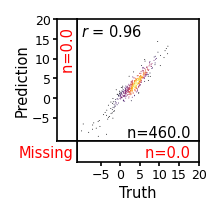

In [15]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=10, random_state=1), 
    y_both.sample(n=10, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_seq_nor_transduction_correlation_train.pdf',dpi=300,bbox_inches='tight')

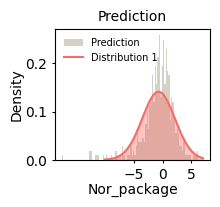

In [16]:
data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10,7, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_transduction/1st_seq_nor_transduction_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [17]:
AA = test_df[array].values
X = test_df.drop(columns=[array,'Y--transduction'])
Y = test_df['Y--transduction'].values
preds_df = predict(model, X, array, Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

2/2 [==============================] - 0s 0s/step

MSE of predictions vs true labels: 0.5982518792152405


0.9426629762236927

In [ ]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=10, random_state=1), 
    y_both.sample(n=10, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/1st_results/nor_transduction/1st_vae_seq_nor_transduction_correlation_test.pdf',dpi=300,bbox_inches='tight')

In [ ]:
data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10,7, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/1st_results/nor_transduction/1st_seq_nor_transduction_distribution_test.pdf',dpi=300,bbox_inches='tight')